# Libraries

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gower
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Functions

In [82]:
def is_high_season(date):
    year = date.year
        #verano, asueto revolución, invierno, asueto constitución, asueto petróleo
    if (pd.Timestamp(year=year, month=7, day=17) <= date <= pd.Timestamp(year=year, month=8, day=27)) or \
       (pd.Timestamp(year=year, month=11, day=18) <= date <= pd.Timestamp(year=year, month=11, day=20)) or \
       (pd.Timestamp(year=year, month=12, day=18) <= date <= pd.Timestamp(year=year+1, month=1, day=5)) or \
       (pd.Timestamp(year=year, month=2, day=3) <= date <= pd.Timestamp(year=year, month=2, day=5)) or \
       (pd.Timestamp(year=year, month=3, day=16) <= date <= pd.Timestamp(year=year, month=3, day=18)) or \
        (pd.Timestamp(year=year, month=3, day=25) <= date <= pd.Timestamp(year=year, month=4, day=7)):
        return 1
    return 0

In [83]:
def find_dbscan_clusters(df_scaled, max_clusters, start_eps=0.1, end_eps=2.0, step_eps=0.1, min_samples=5):
    for eps in np.arange(start_eps, end_eps, step_eps):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise label (-1)
        print(f"eps: {eps:.2f}, clusters: {n_clusters}")
        if n_clusters <= max_clusters:
            return labels, eps
    return None, None

# EDA

In [84]:
reservations = pd.read_csv('C:\\Users\\axelm\\Downloads\\QueryGrosera_v4.csv', encoding='latin1')
reservations.tail()

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida
79981,63042,LUXURY 1K SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,RESERVACION EN TRANSICION,735,2,2,0,1,1,132946.80,2019-03-14,2019-03-14,2019-03-14
79982,40799,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,RESERVACION O (R)REGISTRO,735,2,2,0,28,1,145544.00,2020-03-21,2021-01-13,2021-02-10
79983,60997,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,SALIDA,735,2,2,0,52,1,166296.00,2019-02-12,2019-02-13,2019-04-06
79984,52804,MASTER SUITE 1KSN12GMS,GMS,WALK IN ...,LADA 800 NACIONAL68 ...,CLIENTES PARTICULARES ...,SALIDA,735,2,2,0,63,1,201474.00,2019-07-17,2020-01-11,2020-03-14
79985,43773,ESTD DB SN12AST,AST,WALK IN ...,LADA 800 NACIONAL68 ...,CIRCULO AZUL ELITE ...,RESERVACION O (R)REGISTRO,735,2,2,0,5,1,655848.00,2020-01-13,2020-12-21,2020-12-26


## Limpieza de datos

### Homologación y NaNs

In [85]:
#Check database columns
reservations.columns.tolist()

['Reserva',
 'Tipo_Habitacion',
 'Clasificacion_tipo_habitacion',
 'Paquete',
 'Canal',
 'Agencia',
 'Estatus_res',
 'Capacidad_hotel',
 'Numero_personas',
 'Numero_adultos',
 'Numero_men',
 'Numero_noches',
 'Numero_habitaciones',
 'IngresoMto',
 'FechaRegistro',
 'FechaLlegada',
 'FechaSalida']

In [86]:
#Make sure that columns that contain dates are actually datetime type
reservations['FechaRegistro'] = pd.to_datetime(reservations['FechaRegistro'])
reservations['FechaLlegada'] = pd.to_datetime(reservations['FechaLlegada'])
reservations['FechaSalida'] = pd.to_datetime(reservations['FechaSalida'])

#Check datatype of each column
for column in reservations.columns.tolist():
    print('Datatype ' + str(column) + ': ' + str(reservations[column].dtype))

Datatype Reserva: int64
Datatype Tipo_Habitacion: object
Datatype Clasificacion_tipo_habitacion: object
Datatype Paquete: object
Datatype Canal: object
Datatype Agencia: object
Datatype Estatus_res: object
Datatype Capacidad_hotel: int64
Datatype Numero_personas: int64
Datatype Numero_adultos: int64
Datatype Numero_men: int64
Datatype Numero_noches: int64
Datatype Numero_habitaciones: int64
Datatype IngresoMto: float64
Datatype FechaRegistro: datetime64[ns]
Datatype FechaLlegada: datetime64[ns]
Datatype FechaSalida: datetime64[ns]


In [87]:
for column in reservations.columns.tolist():
    print(f"The number of unique values in {column} is: {reservations[column].nunique()}")

The number of unique values in Reserva is: 79986
The number of unique values in Tipo_Habitacion is: 27
The number of unique values in Clasificacion_tipo_habitacion is: 11
The number of unique values in Paquete is: 4
The number of unique values in Canal is: 14
The number of unique values in Agencia is: 111
The number of unique values in Estatus_res is: 6
The number of unique values in Capacidad_hotel is: 1
The number of unique values in Numero_personas is: 18
The number of unique values in Numero_adultos is: 13
The number of unique values in Numero_men is: 9
The number of unique values in Numero_noches is: 28
The number of unique values in Numero_habitaciones is: 5
The number of unique values in IngresoMto is: 9634
The number of unique values in FechaRegistro is: 481
The number of unique values in FechaLlegada is: 666
The number of unique values in FechaSalida is: 671


In [88]:
categorical_columns = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Agencia', 'Estatus_res']
numeric_columns = ['Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_men', 'Numero_noches', 'Numero_habitaciones', 'IngresoMto']
date_columns = ['FechaRegistro', 'FechaLlegada', 'FechaSalida']

In [89]:
#Detect NaN
reservations.isna().sum()

Reserva                          0
Tipo_Habitacion                  0
Clasificacion_tipo_habitacion    0
Paquete                          0
Canal                            0
Agencia                          0
Estatus_res                      0
Capacidad_hotel                  0
Numero_personas                  0
Numero_adultos                   0
Numero_men                       0
Numero_noches                    0
Numero_habitaciones              0
IngresoMto                       0
FechaRegistro                    0
FechaLlegada                     0
FechaSalida                      0
dtype: int64

### Outliers

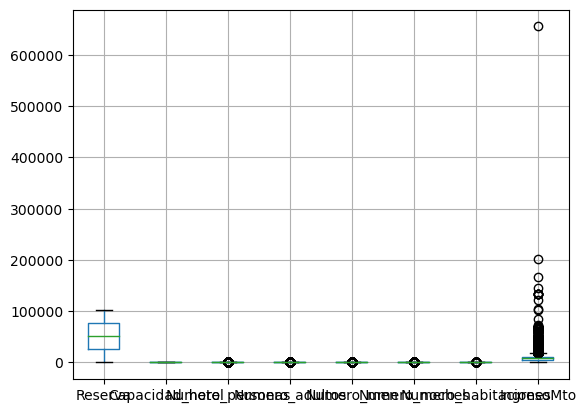

In [90]:
#Identfying outliers

reservations.boxplot()
plt.show()

In [91]:
#Z-score is a metric that defines how many standard deviations a value is from the mean, it can only be used in numeric columns
z_scores = np.abs(stats.zscore(reservations[numeric_columns]))

# Define a threshold for identifying outliers
threshold = 3

# Get a boolean DataFrame indicating the presence of outliers
z_outliers = (z_scores > threshold).any(axis=1)

In [92]:
reservations = reservations[~z_outliers].reset_index()
reservations.drop(columns = ['index'], inplace = True)

reservations.tail()

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida
74616,84742,LUXURY 2Q SN12GSU,GSU,WALK IN ...,INTERNET ...,HOTELES S.A.,SALIDA,735,3,3,0,5,1,26520.15,2019-07-12,2019-07-17,2019-07-22
74617,55939,LUXURY 2Q SN12GSU,GSU,WALK IN ...,INTERNET ...,HOTELES S.A.,RESERVACION O (R)REGISTRO,735,2,2,0,4,1,26521.04,2020-03-12,2020-12-28,2021-01-01
74618,1379,LUXURY 2Q SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,SALIDA,735,2,2,0,6,1,26527.44,2019-03-19,2019-12-26,2020-01-01
74619,1378,LUXURY 1K SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,PRICETRAVEL HOLDING ...,SALIDA,735,2,2,0,6,1,26527.56,2019-03-19,2019-12-26,2020-01-01
74620,27417,LUXURY 2Q SN12GSU,GSU,WALK IN ...,LADA 800 NACIONAL68 ...,QUALITY SERVICES MORELIA ...,SALIDA,735,3,3,0,7,1,26572.00,2019-09-21,2019-10-02,2019-10-09


### Additional columns

In [93]:
#Adding a column for identifying high demand season
reservations['Tipo_temporada'] = reservations['FechaLlegada'].apply(is_high_season)

reservations.head()

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida,Tipo_temporada
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16,0
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24,0
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15,0


In [94]:
#Adding a column for calculating how much time had passed since people reserved their room and their arrival to the hotel
reservations['Diferencia_reservacion_llegada'] = reservations['FechaLlegada'] - reservations['FechaRegistro']

reservations.head()

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida,Tipo_temporada,Diferencia_reservacion_llegada
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16,0,36 days
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24,0,0 days
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15,0,1 days


### Graphs

In [95]:
for column in reservations.columns.tolist():
    print(f"The number of unique values in {column} is: {reservations[column].nunique()}")

The number of unique values in Reserva is: 74621
The number of unique values in Tipo_Habitacion is: 27
The number of unique values in Clasificacion_tipo_habitacion is: 11
The number of unique values in Paquete is: 4
The number of unique values in Canal is: 14
The number of unique values in Agencia is: 111
The number of unique values in Estatus_res is: 6
The number of unique values in Capacidad_hotel is: 1
The number of unique values in Numero_personas is: 4
The number of unique values in Numero_adultos is: 4
The number of unique values in Numero_men is: 1
The number of unique values in Numero_noches is: 9
The number of unique values in Numero_habitaciones is: 1
The number of unique values in IngresoMto is: 8696
The number of unique values in FechaRegistro is: 480
The number of unique values in FechaLlegada is: 656
The number of unique values in FechaSalida is: 660
The number of unique values in Tipo_temporada is: 2
The number of unique values in Diferencia_reservacion_llegada is: 406


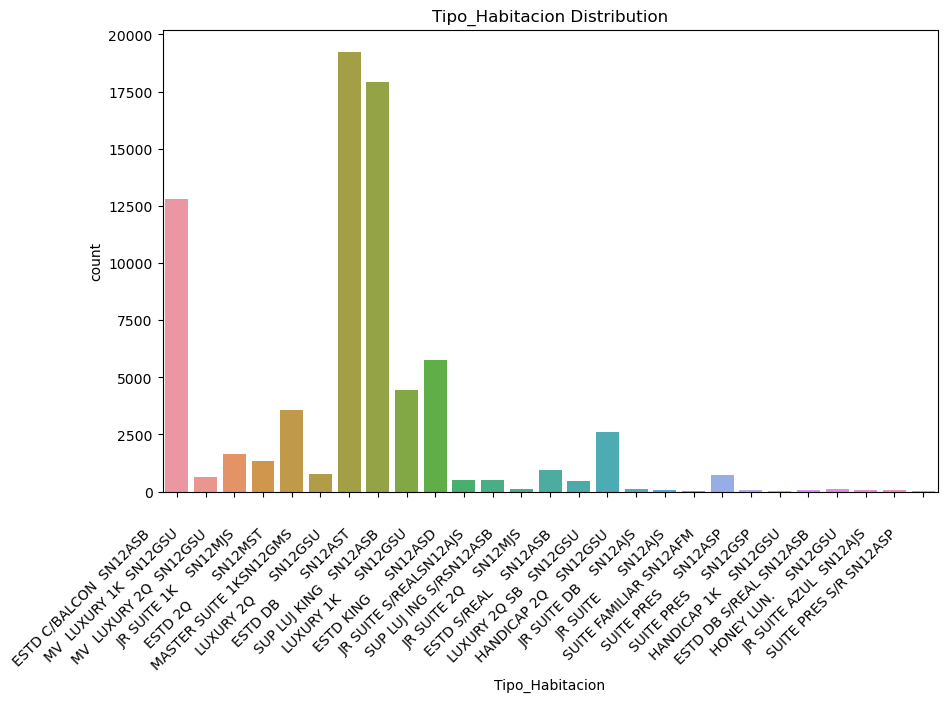

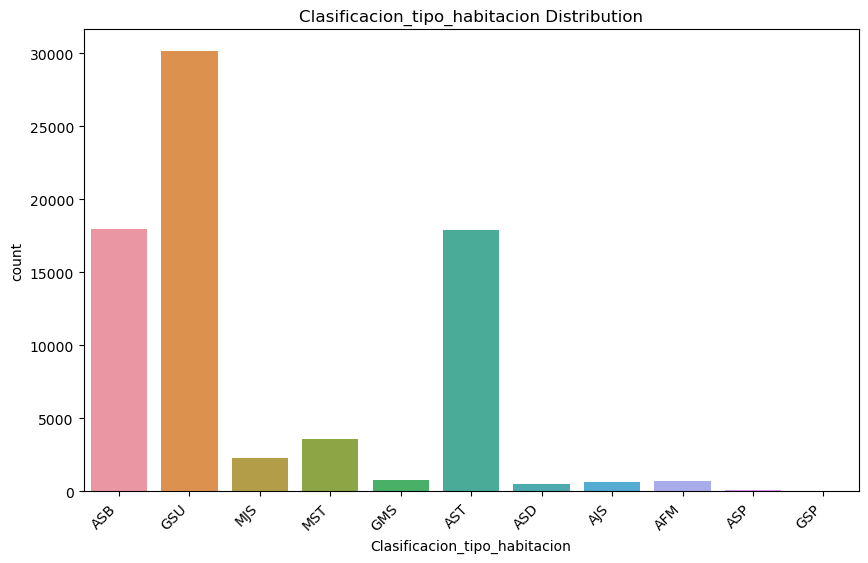

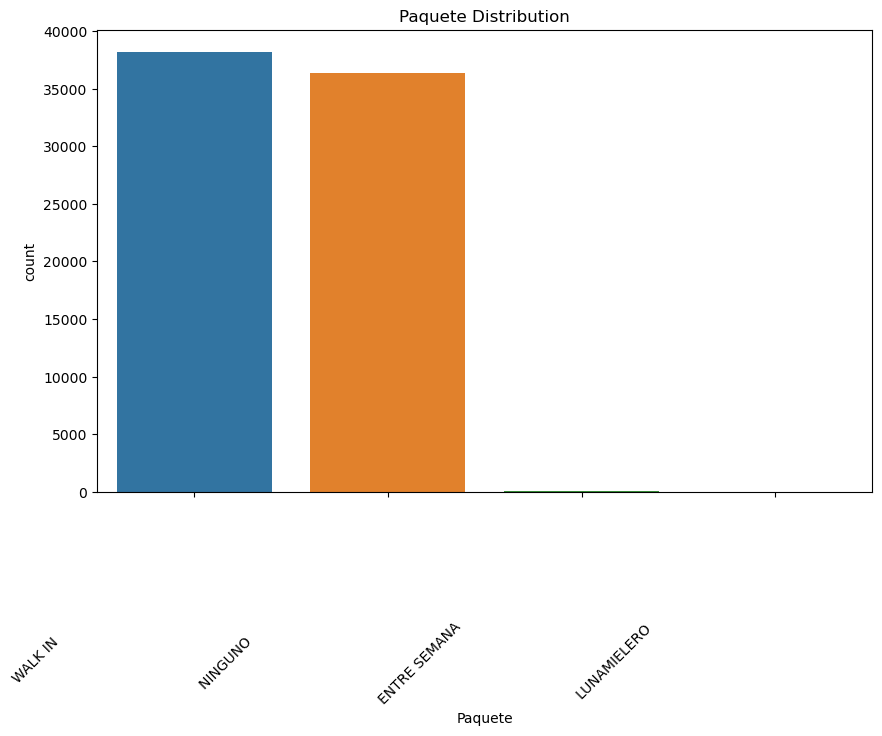

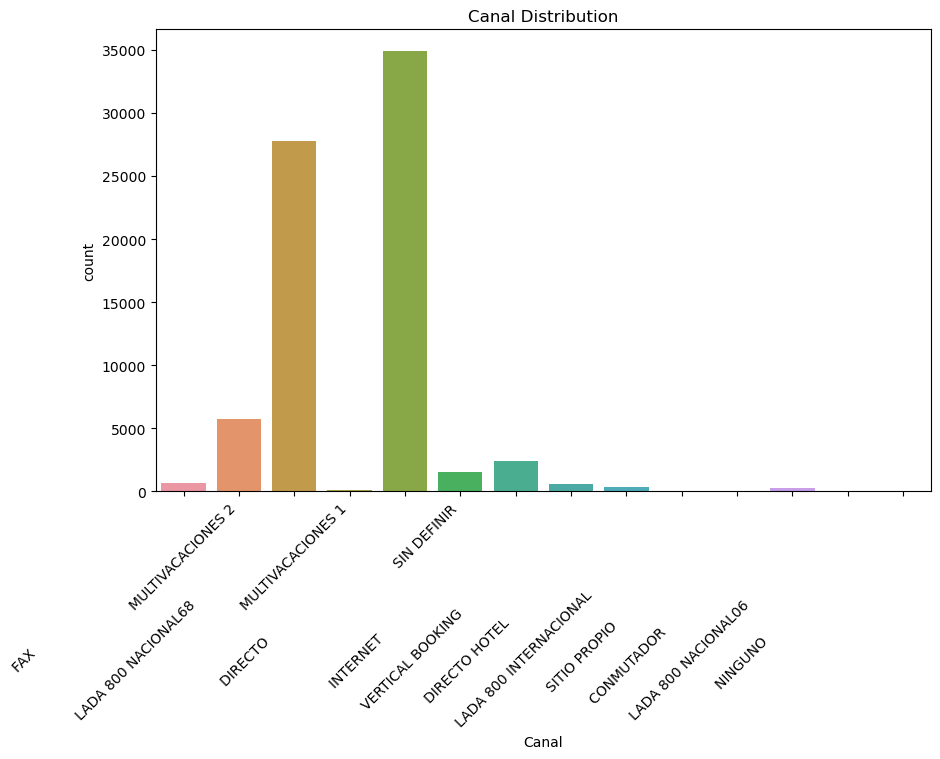

c:\Users\axelm\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


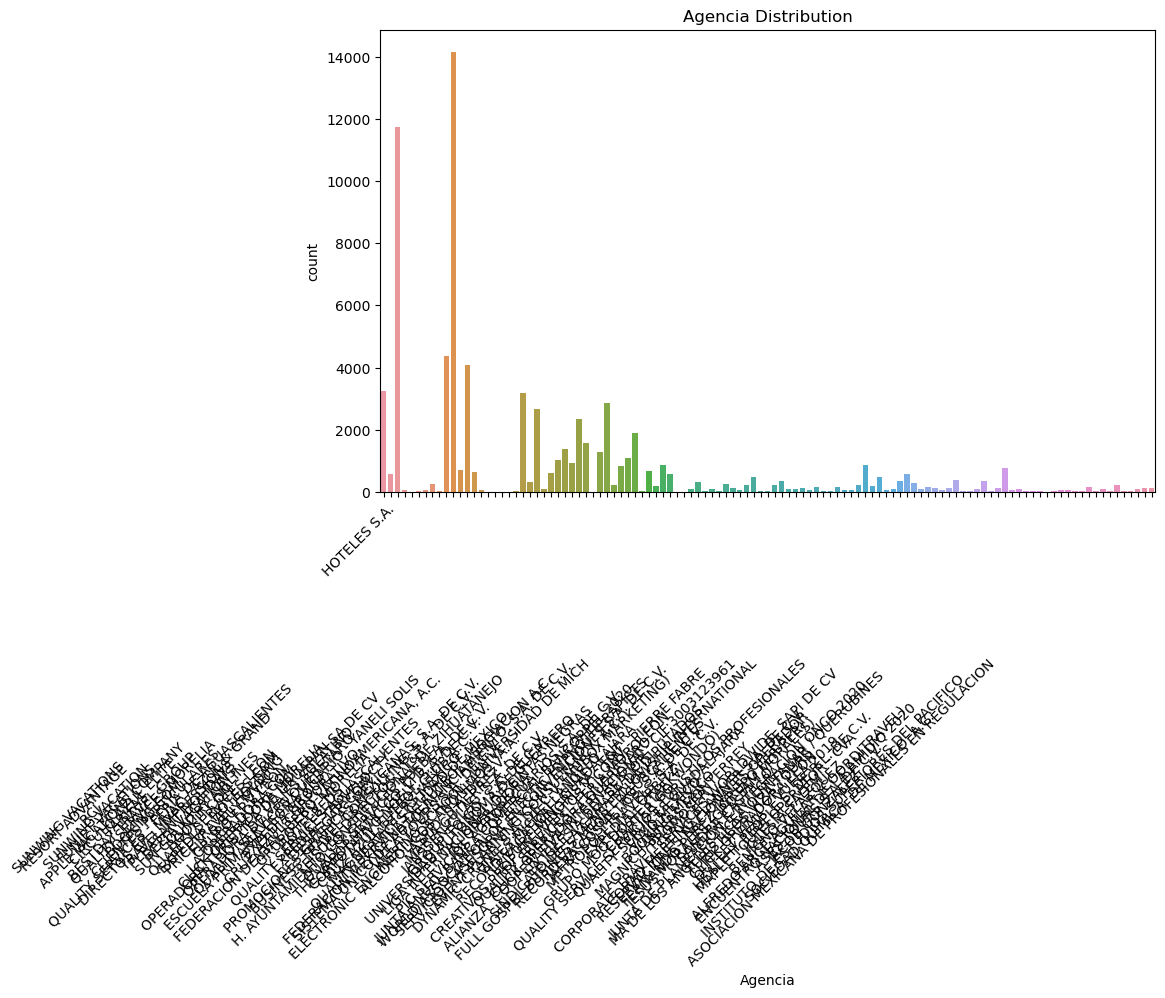

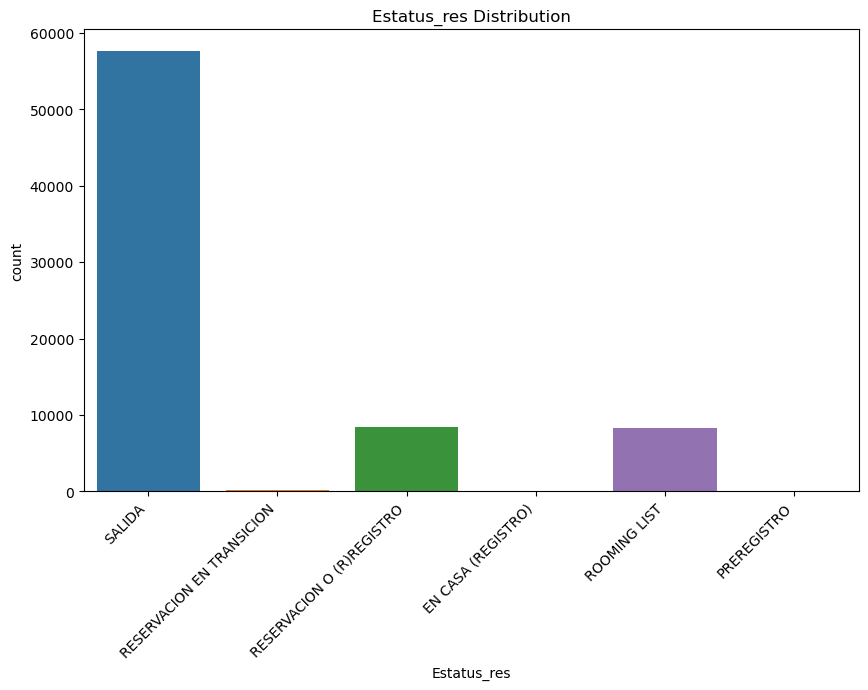

In [96]:
#Distribution of categorical columns

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=reservations)
    plt.title(str(column) + ' Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.show()

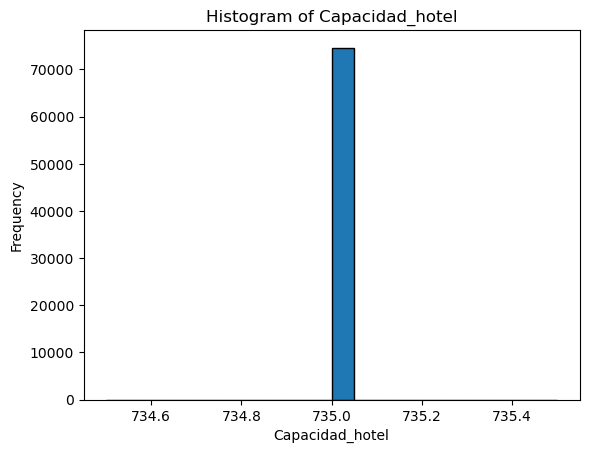

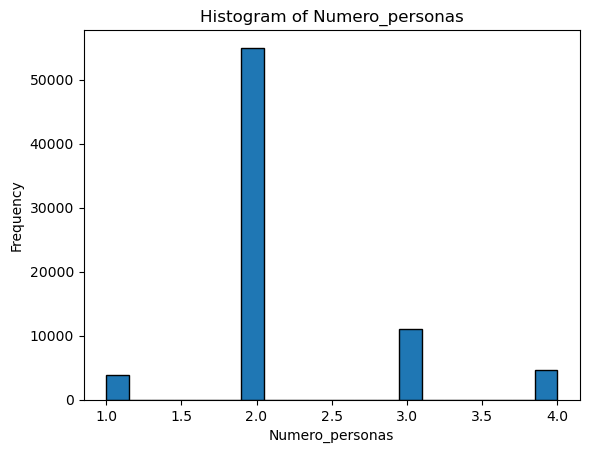

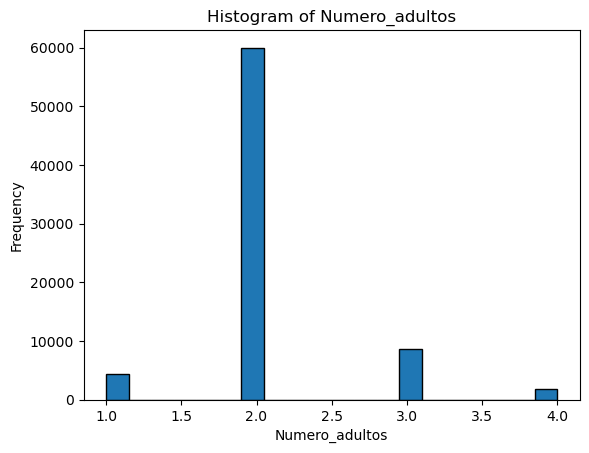

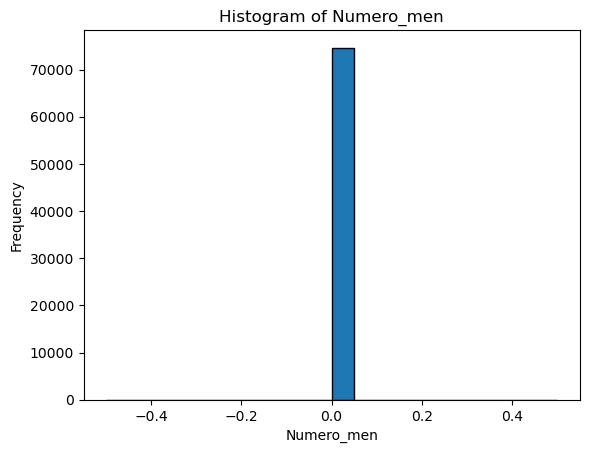

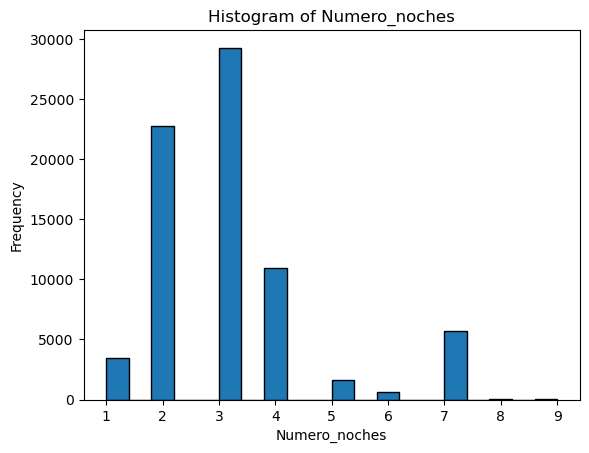

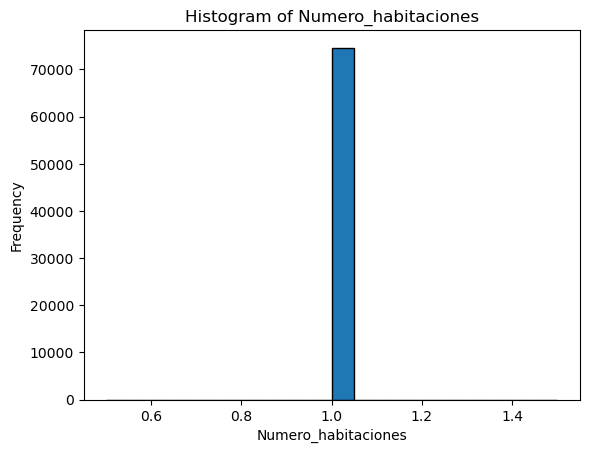

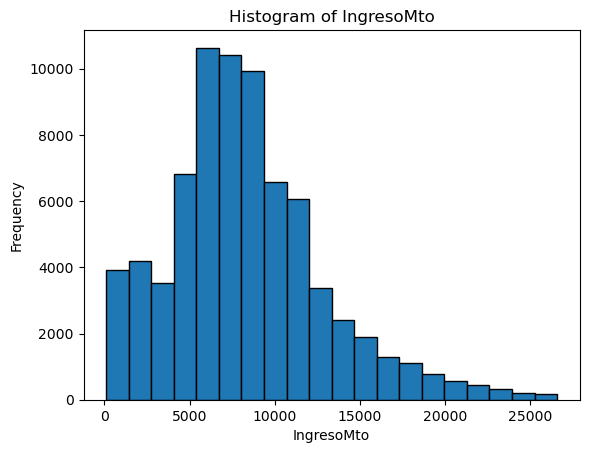

In [97]:
#Distribution of numeric columns
for column in numeric_columns:
    reservations[column].plot.hist(bins=20, edgecolor='black')
    plt.title('Histogram of ' + str(column))
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

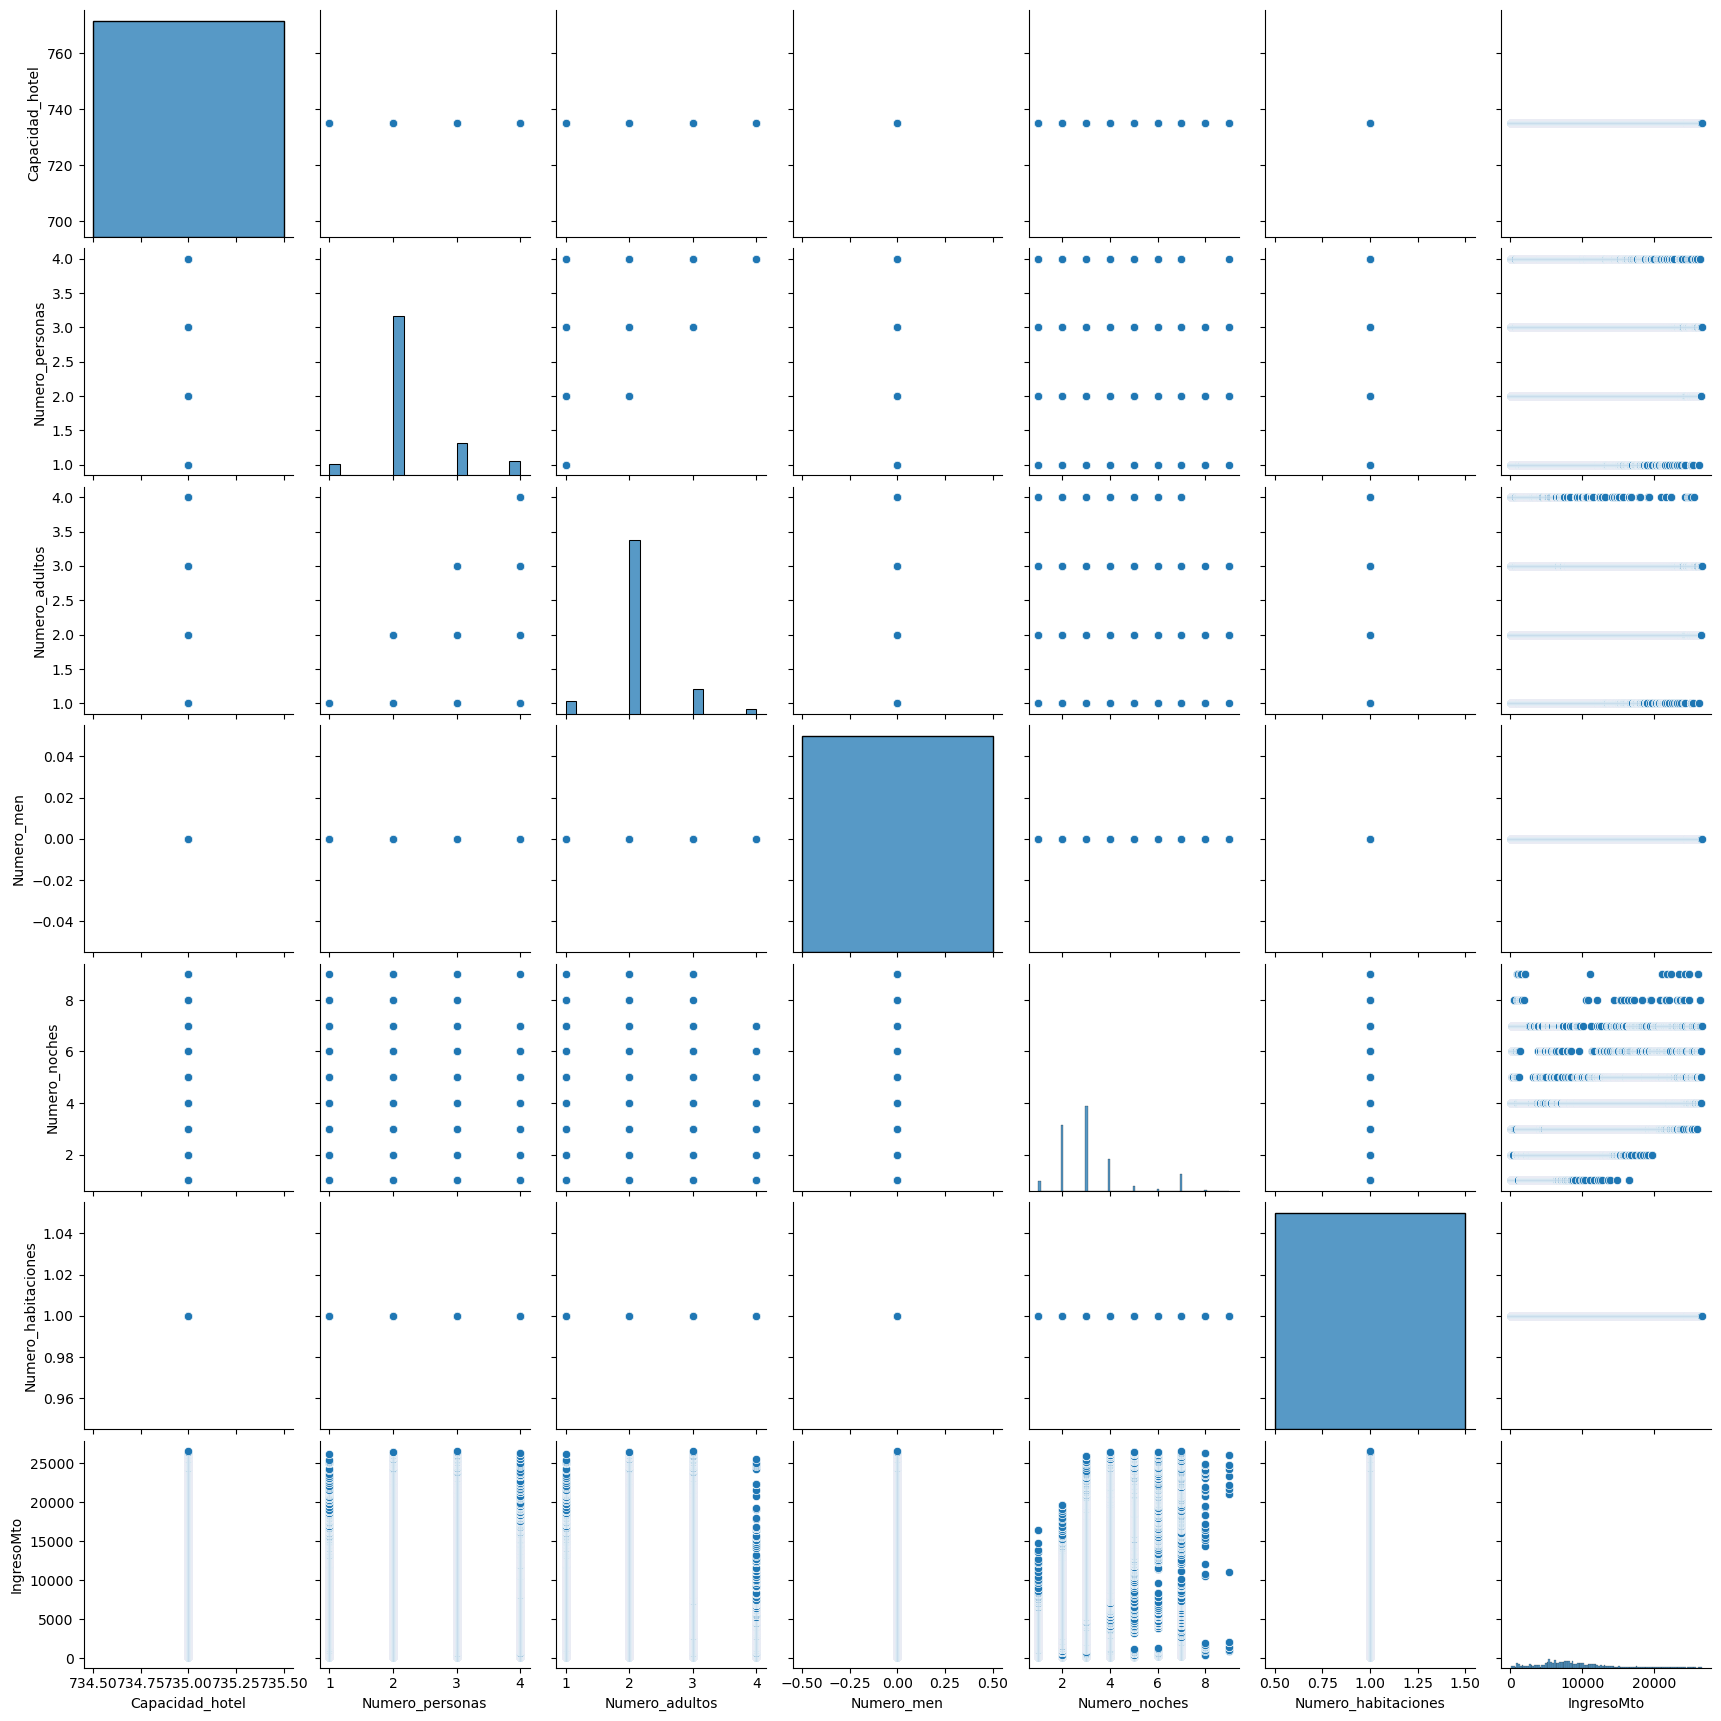

In [98]:
#Understanding relationships between numeric columns
sns.pairplot(reservations[numeric_columns])
plt.show()

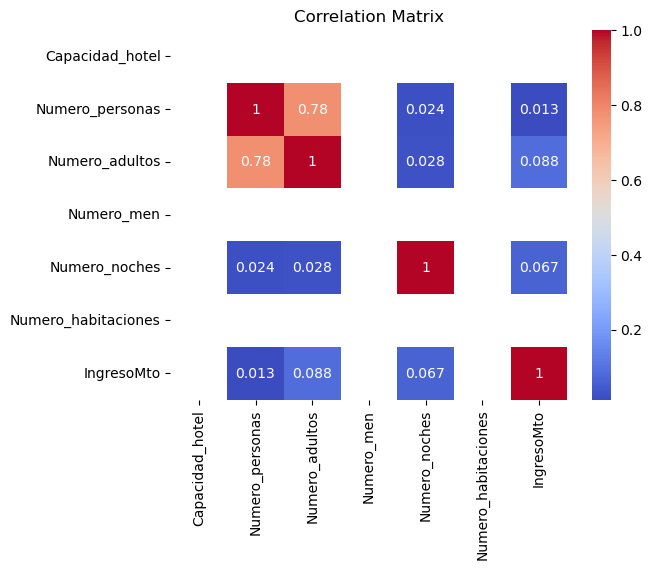

In [99]:
#Checking for correlations
correlation_matrix = reservations[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

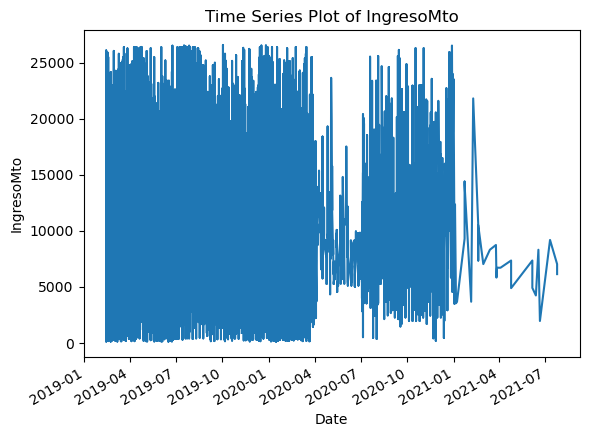

In [77]:
#Trends over time with datetime type columns

reservations.set_index('FechaLlegada')['IngresoMto'].plot.line()
plt.title('Time Series Plot of IngresoMto')
plt.xlabel('Date')
plt.ylabel('IngresoMto')
plt.show()

In [100]:
#Data summary
reservations.describe()

,Reserva,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,Tipo_temporada,Diferencia_reservacion_llegada
count,74621.00,74621.00,74621.00,74621.00,74621.00,74621.00,74621.00,74621.00,74621.00,74621
mean,51583.13,735.00,2.22,2.10,0.00,3.13,1.00,8318.86,0.18,87 days 04:54:55.436941344
std,29451.38,0.00,0.63,0.50,0.00,1.43,0.00,4546.34,0.39,95 days 19:06:38.487065186
min,0.00,735.00,1.00,1.00,0.00,1.00,1.00,101.60,0.00,-1 days +00:00:00
25%,26308.00,735.00,2.00,2.00,0.00,2.00,1.00,5400.00,0.00,13 days 00:00:00
50%,52294.00,735.00,2.00,2.00,0.00,3.00,1.00,7878.00,0.00,51 days 00:00:00
75%,76926.00,735.00,2.00,2.00,0.00,4.00,1.00,10644.00,0.00,134 days 00:00:00
max,102198.00,735.00,4.00,4.00,0.00,9.00,1.00,26572.00,1.00,611 days 00:00:00


In [101]:
#Two sample T-Test: analyzing if there's a significant difference in the average income between two seasons (high and low demand)

hds_income = reservations[reservations.Tipo_temporada == 1]['IngresoMto']
lds_income = reservations[reservations.Tipo_temporada == 0]['IngresoMto']

t_stat, p_value = stats.ttest_ind(hds_income, lds_income)

print(f'Two-sample t-test: t_statistic: {t_stat}, p-value: {p_value}')

Two-sample t-test: t_statistic: 41.390896652245715, p-value: 0.0


# Limpieza de datos

In [7]:
df = pd.read_csv('C:\\Users\\axelm\\Downloads\\QueryGrosera_v4.csv', encoding='latin1')
df.head()

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15


In [8]:
df.columns.tolist()

['Reserva',
 'Tipo_Habitacion',
 'Clasificacion_tipo_habitacion',
 'Paquete',
 'Canal',
 'Agencia',
 'Estatus_res',
 'Capacidad_hotel',
 'Numero_personas',
 'Numero_adultos',
 'Numero_men',
 'Numero_noches',
 'Numero_habitaciones',
 'IngresoMto',
 'FechaRegistro',
 'FechaLlegada',
 'FechaSalida']

In [9]:
df_cleaned = remove_outliers(df, "IngresoMto", threshold=3)

df_cleaned['FechaLlegada'] = pd.to_datetime(df_cleaned['FechaLlegada'])

df_cleaned['Tipo_temporada'] = df_cleaned['FechaLlegada'].apply(is_high_season)

df_cleaned['Diferencia_reservacion_llegada'] = pd.to_datetime(df_cleaned['FechaLlegada']) - pd.to_datetime(df_cleaned['FechaRegistro'])

df_cleaned.head()

C:\Users\axelm\AppData\Local\Temp\ipykernel_6260\3485774568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['FechaLlegada'] = pd.to_datetime(df_cleaned['FechaLlegada'])
C:\Users\axelm\AppData\Local\Temp\ipykernel_6260\3485774568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tipo_temporada'] = df_cleaned['FechaLlegada'].apply(is_high_season)
C:\Users\axelm\AppData\Local\Temp\ipykernel_6260\3485774568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida,Tipo_temporada,Diferencia_reservacion_llegada
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16,0,36 days
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24,0,0 days
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15,0,1 days


In [10]:
df_cleaned.to_csv('QueryGroseraLimpia.csv', index=False)

# Dummies

In [15]:
columns_to_use = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Estatus_res', 'Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_noches', 'IngresoMto', 'Tipo_temporada']

df_dummies = df_cleaned[columns_to_use]

df_dummies = df_dummies.fillna(0)

df_dummies = df_dummies.replace([np.inf, -np.inf], 0)

# Preprocesamiento con OneHotEncoder para variables categóricas y StandardScaler para ingresos
categorical_features = ['Tipo_Habitacion', 'Clasificacion_tipo_habitacion', 'Paquete', 'Canal', 'Estatus_res', "Tipo_temporada"]
numeric_features = ['Capacidad_hotel', 'Numero_personas', 'Numero_adultos', 'Numero_noches', 'IngresoMto']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

df_dummies = preprocessor.fit_transform(df_dummies)

# Gower

In [14]:
# # define weights
# default_weight = 1
# ingreso_mto_weight = 5

# # initialize weight list
# weights = [default_weight] * df_dummies.shape[1]

# # Find the index of the 'IngresoMto' column and assign the specific weight
# ingreso_mto_index = df_dummies.columns.get_loc('IngresoMto')
# weights[ingreso_mto_index] = ingreso_mto_weight

In [15]:
# gower_distances = gower.gower_matrix(df_dummies, weight = weights)

In [16]:
# gower_df = pd.DataFrame(gower_distances, index=df.index, columns=df.index)

# DBSCAN

In [19]:
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_dummies)

In [20]:
# max_clusters = 8

# # Find suitable DBSCAN parameters
# labels, eps = find_dbscan_clusters(df_scaled, max_clusters)

eps: 0.10, clusters: 1991
eps: 0.20, clusters: 2061
eps: 0.30, clusters: 2172
eps: 0.40, clusters: 2235
eps: 0.50, clusters: 2195
eps: 0.60, clusters: 2146
eps: 0.70, clusters: 2110
eps: 0.80, clusters: 2098
eps: 0.90, clusters: 2043
eps: 1.00, clusters: 2020
eps: 1.10, clusters: 1986
eps: 1.20, clusters: 1874
eps: 1.30, clusters: 1866
eps: 1.40, clusters: 1894
eps: 1.50, clusters: 1874
eps: 1.60, clusters: 1734
eps: 1.70, clusters: 1642
eps: 1.80, clusters: 1614
eps: 1.90, clusters: 1581


In [21]:
# if labels is not None:
#     df_cleaned['Cluster'] = labels
#     print(f"Found solution with eps: {eps:.2f}")
# else:
#     print("Could not find a suitable eps value to achieve the desired number of clusters.")

# df_cleaned.head()

Could not find a suitable eps value to achieve the desired number of clusters.


,index,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,Tipo_temporada,Diferencia_reservacion_llegada
0,0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,0,36 days
1,1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,0,89 days
2,2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,0,89 days
3,3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,0,0 days
4,4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,0,1 days


In [16]:
db = DBSCAN(eps=0.5, min_samples=5).fit(df_dummies)

df_cleaned['Cluster'] = db.labels_

df_cleaned.head()

C:\Users\axelm\AppData\Local\Temp\ipykernel_6260\3300780122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = db.labels_


,Reserva,Tipo_Habitacion,Clasificacion_tipo_habitacion,Paquete,Canal,Agencia,Estatus_res,Capacidad_hotel,Numero_personas,Numero_adultos,Numero_men,Numero_noches,Numero_habitaciones,IngresoMto,FechaRegistro,FechaLlegada,FechaSalida,Tipo_temporada,Diferencia_reservacion_llegada,Cluster
0,6576,ESTD C/BALCON SN12ASB,ASB,WALK IN ...,FAX ...,SUNWING VACATIONS ...,SALIDA,735,1,1,0,1,1,101.60,2019-12-10,2020-01-15,2020-01-16,0,36 days,-1
1,82869,MV LUXURY 1K SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days,-1
2,82868,MV LUXURY 2Q SN12GSU,GSU,WALK IN ...,MULTIVACACIONES 2,RESORT ADVANTAGE ...,SALIDA,735,3,2,0,4,1,109.44,2019-03-19,2019-06-16,2019-06-20,0,89 days,-1
3,62469,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,LADA 800 NACIONAL68 ...,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.12,2019-02-22,2019-02-22,2019-02-24,0,0 days,-1
4,63254,JR SUITE 1K SN12MJS,MJS,NINGUNO ...,MULTIVACACIONES 1,RESORT ADVANTAGE ...,SALIDA,735,2,2,0,2,1,113.70,2019-02-12,2019-02-13,2019-02-15,0,1 days,-1


In [17]:
df_cleaned['Cluster'].value_counts()

-1       7745
 5       3231
 275     2977
 488     2974
 423     2837
 491     2513
 16      2114
 30      2062
 2       1940
 4       1805
 643     1269
 15      1179
 299     1161
 291      921
 331      909
 285      860
 585      852
 259      804
 584      785
 335      784
 394      768
 391      670
 110      655
 36       631
 451      600
 564      568
 364      548
 69       513
 339      501
 365      487
 720      441
 390      439
 273      426
 761      424
 73       399
 452      387
 546      371
 606      350
 429      344
 442      337
 489      337
 68       322
 612      315
 698      303
 673      281
 279      272
 363      267
 902      256
 545      250
 277      247
 687      241
 89       236
 1        234
 333      234
 309      233
 874      224
 567      223
 280      220
 381      207
 639      204
 733      204
 45       200
 565      194
 495      193
 879      188
 498      187
 281      183
 7        183
 34       182
 308      181
 91       180
 3    

In [18]:
df_cleaned['Cluster'].nunique()

1058